In [3]:
import sys
!{sys.executable} -m pip install --upgrade --user xgboost

  Using cached xgboost-3.1.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.2-py3-none-win_amd64.whl (72.0 MB)


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
import joblib
import sys


In [2]:
df = pd.read_csv('../data/processed/final_dataset.csv')
df.head()

,Commodity,District,Market,Year,Month,Modal_Price,State,Rainfall,Season,Lag_1_Price,Lag_2_Price,Lag_3_Price
0,Almond (Badam),Kalimpong,Kalimpong,2023,8,5000.000000,West Bengal,352.23,Monsoon,2500.000000,3500.000000,7500.000000
1,Apple,Darjeeling,Matigara,2011,5,7200.000000,West Bengal,119.60,Summer,6500.000000,5750.000000,5137.500000
2,Apple,Darjeeling,Matigara,2011,6,8335.714286,West Bengal,342.25,Monsoon,7200.000000,6500.000000,5750.000000
3,Apple,Darjeeling,Matigara,2011,7,9000.000000,West Bengal,338.41,Monsoon,8335.714286,7200.000000,6500.000000
4,Apple,Kolkata,Mechua,2010,4,6005.333333,West Bengal,66.26,Summer,4567.948718,4079.710145,4056.578947


In [3]:
X = df.drop('Modal_Price', axis=1)
y = df['Modal_Price']

In [4]:
categorical_features = ['Commodity', 'District', 'Market', 'Month', 'Season']
numeric_features = ['Year', 'Rainfall', 'Lag_1_Price', 'Lag_2_Price', 'Lag_3_Price']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ))
])

In [8]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Rainfall',
                                                   'Lag_1_Price', 'Lag_2_Price',
                                                   'Lag_3_Price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Commodity', 'District',
                                                   'Market', 'Month',
                                                   'Season'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsa...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [9]:
y_pred = xgb_pipeline.predict(X_test)

In [12]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 902.77
R² Score: 0.92
MAE: 351.26


In [13]:
comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
comparison.head(20) 

,Actual,Predicted
0,1536.538462,1507.852295
1,1813.269231,1806.531616
2,4196.551724,4323.219238
3,2690.263158,2774.533203
4,3873.333333,3806.520996
5,882.608696,1171.690308
6,1325.000000,1708.778198
7,4592.307692,4520.076660
8,1663.461538,1844.398682
9,2308.333333,2323.368896


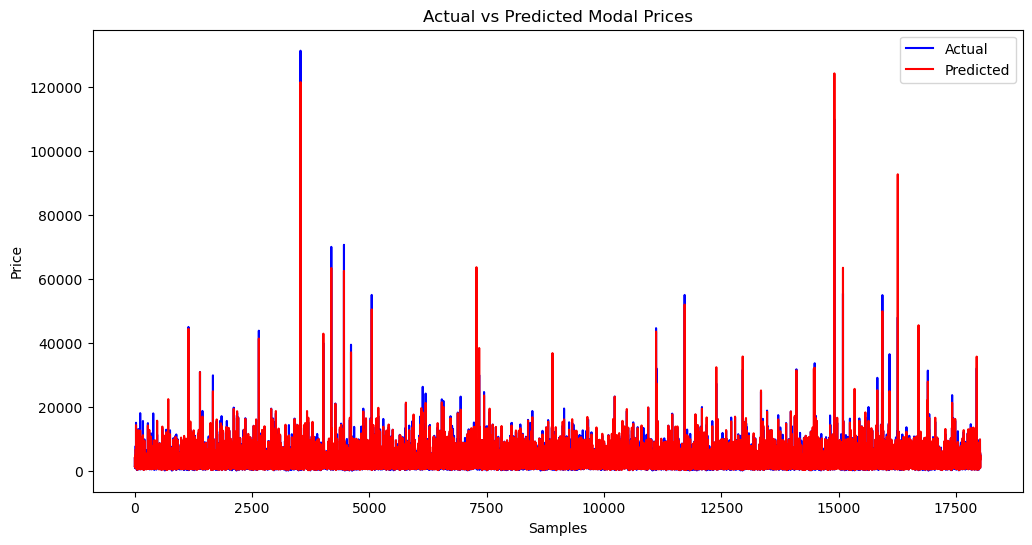

In [16]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title("Actual vs Predicted Modal Prices")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.show()

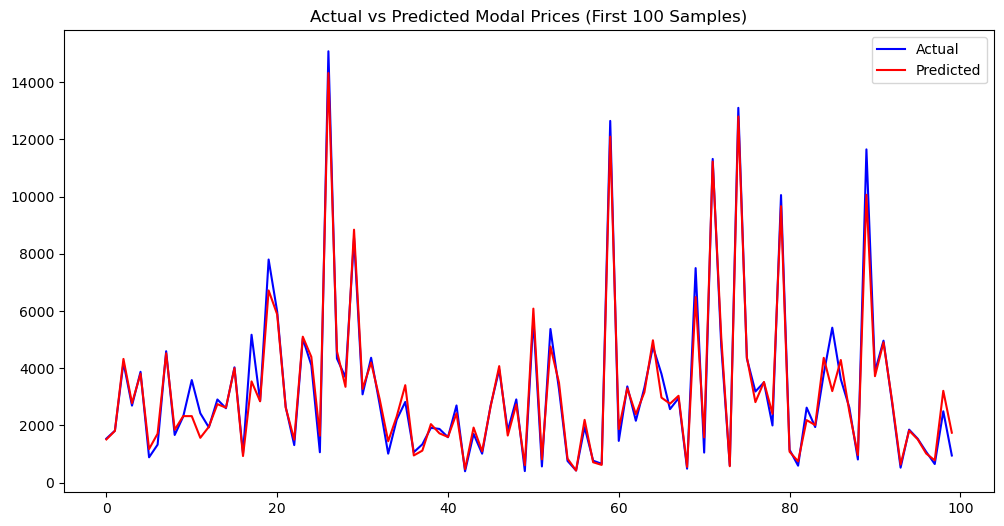

In [17]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred[:100], label='Predicted', color='red')
plt.title("Actual vs Predicted Modal Prices (First 100 Samples)")
plt.legend()
plt.show()

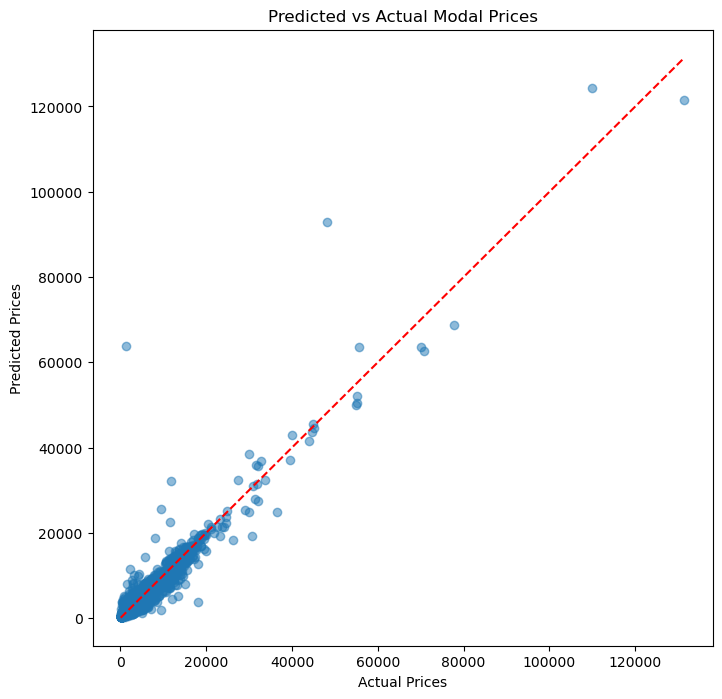

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Modal Prices")
plt.show()

In [19]:
comparison.to_csv('../data/processed/predicted_vs_actual.csv', index=False)

In [24]:
import os
os.makedirs("../models", exist_ok=True)
joblib.dump(xgb_pipeline, "../models/xgb_modal_price_pipeline.pkl")


['../models/xgb_modal_price_pipeline.pkl']